[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/07.dimensionality-reduction/b.svd-and-regression.ipynb)

# SINGULAR VALUE DECOMPOSITION AND REGRESSION

We will here explain how Singular Value Decomposition can be used as a pre-processing step for supervised learning tasks.

In [1]:
import numpy as np
import pandas as pd # For dataframes (tables)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

!pip install category_encoders
import category_encoders as ce

## Download the code I prepared for you
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/feature_engineering.py

from andrea_models import AndreaLinearRegression # In the course library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 877.3 kB/s eta 0:00:00
--2023-02-06 10:38:38--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2023-02-06 10:38:39 (44.1 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2023-02-06 10:38:39--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/feature_engineering.py
Resolving raw.githubusercontent.com (raw.gi

# Usual preprocessing
No need to read it carefully

In [2]:
dataset_to_use = 'A'
mydatasets_folder = "https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/"
filename = "df."+ dataset_to_use+"_2.csv"
complete_name = mydatasets_folder+filename
!wget $complete_name

--2023-02-06 10:38:41--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/df.A_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315832 (308K) [text/plain]
Saving to: ‘df.A_2.csv’

df.A_2.csv          100%[===================>] 308.43K  --.-KB/s    in 0.04s   

2023-02-06 10:38:41 (7.11 MB/s) - ‘df.A_2.csv’ saved [315832/315832]



In [3]:
df = pd.read_csv(complete_name)
df.head()

,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,...,BufferValid,KBytesReceived,label,label_num,KBytesReceived_log,PacketsSent_log,PacketsReceived_log,BytesSent_log,BytesReceived_log,BufferProgress_log
0,6.1,29,57,2372,79344,192.168.1.190,173.194.55.23,QUIC,29,57,...,True,79.344,q480p,480,4.373793,3.401197,4.060443,7.771910,11.281561,0.005164
1,5.8,7,39,625,52973,192.168.1.190,74.125.155.199,QUIC,4,36,...,True,52.973,q360p,360,3.969782,2.079442,3.688879,6.439350,10.877557,0.004833
2,7.3,16,23,1056,34178,192.168.1.190,74.125.155.201,TCP,16,23,...,True,34.178,q720p,720,3.531582,2.833213,3.178054,6.963190,10.439367,0.005473
3,39.2,14,29,3377,36821,192.168.1.190,172.217.135.40,0,0,0,...,True,36.821,q144p,144,3.606068,2.708050,3.401197,8.125039,10.513851,0.009268
4,4.6,9,77,900,104389,192.168.1.190,173.194.184.103,QUIC,9,77,...,True,104.389,q360p,360,4.648124,2.302585,4.356709,6.803505,11.555889,0.006599


Remove the columns that are redundant or  that we cannot observe in a real network or we think are superflous.

In [4]:
cols_to_remove = list(["label", "EpochTime", "StartTime", "KBytesReceived"])
columns_we_cannot_observe = list(["Buffering", "Paused", "Playing", "CollectData",
              "PlaybackProgress", "Length", "BufferHealth", "BufferProgress", 
              "BufferValid"])
log_transformed_cols = list(df.columns[df.columns.str.contains('_log')] )
ip_address_cols  = list( df.columns[df.columns.str.contains('IP')] )
cols_to_remove += columns_we_cannot_observe
cols_to_remove += log_transformed_cols
cols_to_remove += ip_address_cols
print("Removing the following columns: ", cols_to_remove)

df = df.drop(cols_to_remove, axis=1)


Removing the following columns:  ['label', 'EpochTime', 'StartTime', 'KBytesReceived', 'Buffering', 'Paused', 'Playing', 'CollectData', 'PlaybackProgress', 'Length', 'BufferHealth', 'BufferProgress', 'BufferValid', 'KBytesReceived_log', 'PacketsSent_log', 'PacketsReceived_log', 'BytesSent_log', 'BytesReceived_log', 'BufferProgress_log', 'IPSrc0', 'IPDst0', 'IPSrc1', 'IPDst1', 'IPSrc2', 'IPDst2', 'IPSrc3', 'IPDst3', 'IPSrc4', 'IPDst4', 'IPSrc5', 'IPDst5', 'IPSrc6', 'IPDst6', 'IPSrc7', 'IPDst7', 'IPSrc8', 'IPDst8', 'IPSrc9', 'IPDst9', 'IPSrc10', 'IPDst10', 'IPSrc11', 'IPDst11', 'IPSrc12', 'IPDst12', 'IPSrc13', 'IPDst13', 'IPSrc14', 'IPDst14', 'IPSrc15', 'IPDst15', 'IPSrc16', 'IPDst16', 'IPSrc17', 'IPDst17', 'IPSrc18', 'IPDst18', 'IPSrc19', 'IPDst19', 'IPSrc20', 'IPDst20', 'IPSrc21', 'IPDst21', 'IPSrc22', 'IPDst22', 'IPSrc23', 'IPDst23', 'IPSrc24', 'IPDst24', 'IPSrc25', 'IPDst25']


One-hot encode all the columns relative to protocol

In [5]:
protocol_columns =  df.columns[df.columns.str.contains('Protocol')]
print("The columns concerning protocols are ", protocol_columns)

encoder = ce.OneHotEncoder(cols=protocol_columns, use_cat_names=True)
df = encoder.fit_transform(df)
df.head()

The columns concerning protocols are  Index(['Protocol0', 'Protocol1', 'Protocol2', 'Protocol3', 'Protocol4',
       'Protocol5', 'Protocol6', 'Protocol7', 'Protocol8', 'Protocol9',
       'Protocol10', 'Protocol11', 'Protocol12', 'Protocol13', 'Protocol14',
       'Protocol15', 'Protocol16', 'Protocol17', 'Protocol18', 'Protocol19',
       'Protocol20', 'Protocol21', 'Protocol22', 'Protocol23', 'Protocol24',
       'Protocol25'],
      dtype='object')


,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,Protocol0_QUIC,Protocol0_TCP,Protocol0_0,Protocol0_TLSv1.2,Protocol0_UDP,...,PacketsSent24,PacketsReceived24,BytesSent24,BytesReceived24,Protocol25_0.0,PacketsSent25,PacketsReceived25,BytesSent25,BytesReceived25,label_num
0,6.1,29,57,2372,79344,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,480
1,5.8,7,39,625,52973,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,360
2,7.3,16,23,1056,34178,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,720
3,39.2,14,29,3377,36821,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,144
4,4.6,9,77,900,104389,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,360


Note that for the protocols of the least important connections (for instance `Protocol25_0.0`, the protocol of the least important connection), only 0.0 value exists. This means there is no traffic for such connections, for all the samples. In other words, there are no such connections.

In [6]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=19)

X_train = df_train.drop("label_num", axis=1)
y_train = df_train["label_num"]

X_test = df_test.drop("label_num", axis=1)
y_test = df_test["label_num"]

# Linear regression on the original dataset

**Task**: Predict the resolution of videos consumed by users based on network information.

In [7]:
model = AndreaLinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
RMSE

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


286943.9842150007

# Linear regression on the reduced dataset


### Hands-on
Perform **standard scaling**

In [8]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train)

**Perform Singular Value Decomposition** on the features of the scaled training set

In [9]:
U,Sigma,Vt = np.linalg.svd(X_train_sca)

**Decide how many components** you want to keep. To this aim, visualize the variance captured by each component


Text(0.5, 1.0, 'Normalized variance explained of X_train')

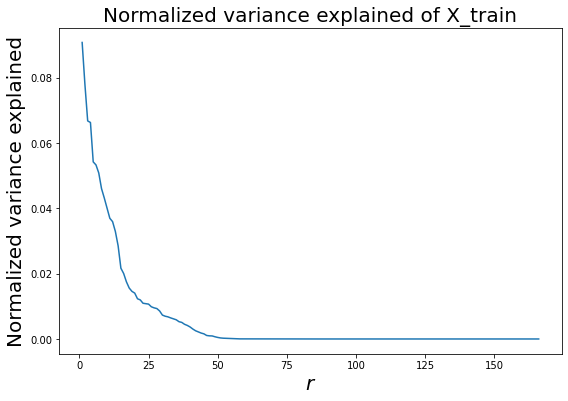

In [10]:
Sigma_squared = np.square(Sigma)
total_variance = sum(Sigma_squared)

### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(Sigma_squared)),Sigma_squared/total_variance)
plt.xlabel(r'$r$',size=20)
plt.ylabel(r'Normalized variance explained',size=20)
plt.title(r'Normalized variance explained of X_train',size=20)

Let us plot the variance we capture when we keep $r$ components

Text(0.5, 1.0, 'Cumulative normalized variance explained of X_train')

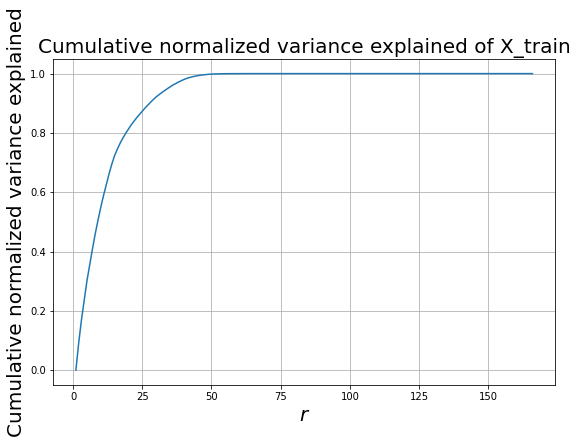

In [11]:
cumul = [ sum(Sigma_squared[0:i]/total_variance) for i in range(len(Sigma_squared))]

### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(cumul)),cumul)
plt.xlabel(r'$r$',size=20)
plt.ylabel(r'Cumulative normalized variance explained',size=20)
plt.grid(b=True)
plt.title(r'Cumulative normalized variance explained of X_train',size=20)

From the plots it is clear we can just keep 50 components.

In [12]:
r=50

**Compute the reduced training set**

In [13]:
V = Vt.T  # We are interested in V (while the Vt given by linalg.svd was 
          # the transpose of V)
V_r = V[:, :r] # Take the first k columns
X_train_reduced = X_train_sca.dot(V_r)

**Fit a linear model** on the reduced training set

In [14]:
model = AndreaLinearRegression()
model.fit(X_train_reduced, y_train)


AndreaLinearRegression()

We can now use this model to make prediction on the reduced test set.


**Project the test samples onto the reduced vectorial space**

**Make the prediction** on the reduced samples.

In [17]:
X_test_sca = scaler.transform(X_test)
X_test_reduced = X_test_sca.dot (V_r)

In [18]:
y_pred = model.predict(X_test_reduced)

MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
RMSE

453.7876040634693

Much better!